In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import time
import json

from IPython import display

In [3]:
BATCH_SIZE = 32
MAP_SIZE = 32
LR_D = LR_G = 0.00005

In [4]:
N = 32

def generate_rect(x, y, w, h):
  data = np.zeros((N,N))
  data[x:x+w+1, y:y+h+1] = 1
  data[x+1:x+w, y+1:y+h] = 0
  #data = np.reshape(data, (N*N))
  return data

train_images = []

for x in range(0, N-2):
  for y in range(0, N-2):
    for w in range(2,N):
      for h in range(2,N):
        if x+w<N and y+h<N:
          train_images.append(generate_rect(x,y,w,h))
train_images = np.array(train_images).astype('int32')
#train_images = train_images[np.random.choice(np.shape(train_images)[0], 20000, replace=False)]

print(np.shape(train_images))

(216225, 32, 32)


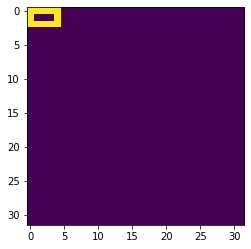

In [ ]:
plt.imshow(train_images[2])

In [ ]:
train_size, x_dims, y_dims = train_images.shape
z_dims = np.amax(train_images) + 1 # Number of different title types
print(z_dims)
train_images_onehot = np.eye(z_dims, dtype='uint8')[train_images]
print(train_images_onehot.shape) # (train_size, x_dims, y_dims, z_dims)

train_images = np.zeros((train_size, MAP_SIZE, MAP_SIZE, z_dims))
print(train_images.shape)

# TODO: Change empty space encoding here if different
train_images[:, :, :, 1] = 0.0  # Fill with empty space 

train_images[:train_size, :x_dims, :y_dims, :] = train_images_onehot
print(train_images.shape)

2
(216225, 32, 32, 2)
(216225, 32, 32, 2)
(216225, 32, 32, 2)


In [ ]:
def get_random_images():
    sample_images = train_images[np.random.choice(np.shape(train_images)[0], 2000, replace=False)]
    train_size, x_dims, y_dims = sample_images.shape
    z_dims = np.amax(sample_images) + 1 # Number of different title types
    train_images_onehot = np.eye(z_dims, dtype='uint8')[sample_images]

    sample_images = np.zeros((train_size, MAP_SIZE, MAP_SIZE, z_dims))

    # TODO: Change empty space encoding here if different
    sample_images[:, :, :, 1] = 0.0  # Fill with empty space 

    sample_images[:train_size, :x_dims, :y_dims, :] = train_images_onehot
    sample_dataset = tf.data.Dataset.from_tensor_slices(sample_images).shuffle(sample_images.shape[0]).batch(BATCH_SIZE)
    
    return (sample_dataset)
    

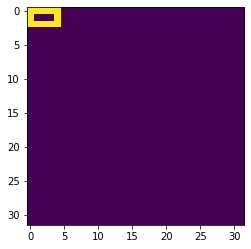

In [ ]:
plt.imshow(np.argmax(train_images[2], axis=2))

In [5]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, LeakyReLU, Conv2DTranspose
from keras.models import Sequential
img_cols, img_rows, channels = 32,32,2
optimizer = tf.optimizers.Adam(0.0002, 0.5)
noise_dim = 128

In [6]:
def make_discriminator_model(n_extra_layers=0):
   discriminator = Sequential()

   discriminator.add(Dense(1024, input_dim=img_rows*img_cols*channels))
   discriminator.add(LeakyReLU(0.2))

   discriminator.add(Dense(512))
   discriminator.add(LeakyReLU(0.2))

   discriminator.add(Dense(256))
   discriminator.add(LeakyReLU(0.2))

   discriminator.add(Dense(1, activation='sigmoid'))

   discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
   return discriminator

In [7]:
def make_generator_model(n_extra_layers=0):
   generator = Sequential()
    
   generator.add(Dense(256, input_dim=noise_dim))
   generator.add(LeakyReLU(0.2))

   generator.add(Dense(512))
   generator.add(LeakyReLU(0.2))

   generator.add(Dense(1024))
   generator.add(LeakyReLU(0.2))

   generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    
   generator.compile(loss='binary_crossentropy', optimizer=optimizer)
   return generator

In [8]:
discriminator = make_discriminator_model()
generator = make_generator_model()

In [9]:
print(discriminator.summary())
print(generator.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 2

In [ ]:
print(generator(np.random.rand(1, 128)).shape)
print(discriminator(np.random.rand(1, MAP_SIZE*MAP_SIZE*z_dims)).shape)

(1, 2048)
(1, 1)


In [10]:
def get_discriminator_loss(real_output, generated_output):
  real_loss = tf.reduce_mean(real_output)
  generated_loss = tf.reduce_mean(generated_output)
  total_loss = real_loss - generated_loss

  return total_loss


def get_generator_loss(generated_output):
  return -tf.reduce_mean(generated_output)

In [11]:
discriminator_optimizer = tf.optimizers.RMSprop(LR_D)
generator_optimizer = tf.optimizers.RMSprop(LR_G)

In [12]:
def generate_and_save_images(model, epoch, test_input, savefig=False):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10, 10))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.argmax(predictions[i], axis=2))
    plt.axis('off')

  if savefig:
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [13]:
EPOCHS = 10000
noise_size = 128
num_examples = 8

# Use same random vector to see evolution of generated images over time
random_vector_for_generation = tf.random.normal([num_examples, noise_size])

In [14]:
def train_step(images, update_generator=False):
  # Generating noise from a normal distribution
  noise = tf.random.normal([BATCH_SIZE, noise_size])

  for w in discriminator.trainable_variables:
    w.assign(tf.clip_by_value(w, -0.01, 0.01))
    
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    generated_output = discriminator(generated_images, training=True)

    gen_loss = get_generator_loss(generated_output)
    disc_loss = get_discriminator_loss(real_output, generated_output)
        
    gradients_of_discriminator = disc_tape.gradient(-disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    if update_generator:
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  return gen_loss, disc_loss

In [ ]:
len(train_dataset)
print("active runtime 222")

NameError: name 'train_dataset' is not defined

In [15]:
def train(dataset, epochs):
  gen_iterations = 0
  for epoch in range(epochs):
    start = time.time()
    disc_iterations = 0
    
    sample_images = train_images[np.random.choice(np.shape(train_images)[0], 2000, replace=False)]
    train_size, x_dims, y_dims = sample_images.shape
    z_dims = np.amax(sample_images) + 1 # Number of different title types
    train_images_onehot = np.eye(z_dims, dtype='uint8')[sample_images]

    sample_images = np.zeros((train_size, MAP_SIZE, MAP_SIZE, z_dims))

    # TODO: Change empty space encoding here if different
    sample_images[:, :, :, 1] = 0.0  # Fill with empty space 

    sample_images[:train_size, :x_dims, :y_dims, :] = train_images_onehot
    sample_dataset = tf.data.Dataset.from_tensor_slices(sample_images).shuffle(sample_images.shape[0]).batch(BATCH_SIZE)
    
    for i, images in enumerate(sample_dataset):
      images = np.reshape(images, (images.shape[0],img_rows*img_cols*channels))
      if disc_iterations == 0:
        if gen_iterations < 25 or gen_iterations % 500 == 0:
          disc_iterations = 100
        else:
          disc_iterations = 5
      if disc_iterations == 1 or i == len(sample_dataset) - 1:
        gen_loss, disc_loss = train_step(images, True)
        gen_iterations += 1
      else:
        gen_loss, disc_loss = train_step(images)
      disc_iterations -= 1

    #display.clear_output(wait=True)
    # Save generator every 500 epochs
    if (epoch + 1) % 500 == 0:
        print("Epoch: ", epoch)
        print("Generator Loss: ", gen_loss)
        print("Discriminator Loss: ", disc_loss)
    #  generate_and_save_images(generator, epoch + 1, 
    #                           random_vector_for_generation, True)
    #  generator.save('models/generator_baseline_' + str(epoch + 1))
    #else:
    #  generate_and_save_images(generator, epoch + 1, 
    #                           random_vector_for_generation)

    #print ('Time taken for epoch {} is {} sec'.format(epoch + 1, 
    #                                                  time.time() - start))
    #print("Generator Loss: ", gen_loss)
    #print("Discriminator Loss: ", disc_loss)
  # Generate after the final epoch
  #display.clear_output(wait=True)
  # # runtime runtime active active runtime active runtime active active runtime pls activeeeeee
  # # active runtime
  # # brb 10 min active runtime
  # # active runtime active
  # # almost there active runtime active runtime
  # # active runtime
  # # active runtime
  # # active runtime last 1000
  # # active runtime
  #generate_and_save_images(generator,
  #                        epochs,
  #                        random_vector_for_generation)

In [16]:
train(2, EPOCHS)

Epoch:  499
Generator Loss:  tf.Tensor(-4.672449e-10, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(-4.672423e-10, shape=(), dtype=float32)
Epoch:  999
Generator Loss:  tf.Tensor(-4.799043e-11, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(-4.7989803e-11, shape=(), dtype=float32)
Epoch:  1499
Generator Loss:  tf.Tensor(-7.37495e-11, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(-7.374933e-11, shape=(), dtype=float32)
Epoch:  1999
Generator Loss:  tf.Tensor(-8.763796e-11, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(-8.763784e-11, shape=(), dtype=float32)
Epoch:  2499
Generator Loss:  tf.Tensor(-1.6733367e-10, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(-1.6733358e-10, shape=(), dtype=float32)
Epoch:  2999
Generator Loss:  tf.Tensor(-8.484828e-12, shape=(), dtype=float32)
Discriminator Loss:  tf.Tensor(-8.48476e-12, shape=(), dtype=float32)
Epoch:  3499
Generator Loss:  tf.Tensor(-3.32418e-11, shape=(), dtype=float32)
Discriminator Lo

In [17]:
def show_images(noise):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if 2 == 1:
            plt.imshow(image.reshape((32, 32)), cmap='gray')
        else:
            plt.imshow(np.argmax(image.reshape(32, 32, 2), axis=2))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

4/4 [==============================] - 0s 3ms/step


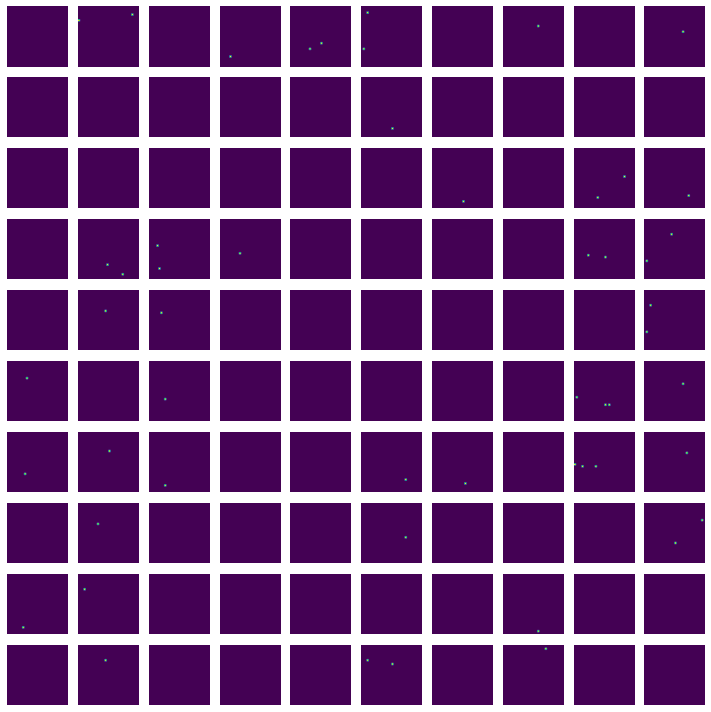

In [26]:
noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)

In [19]:
from google.colab import files

In [20]:
discriminator.save("./discriminator")
generator.save("./generator")

In [21]:
files.download('./discriminator')
files.download('./generator')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
files.download('.')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
files.download('all.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
files.view(".")

<IPython.core.display.Javascript object>

In [29]:
!zip -r './all.zip' '.'

  adding: .config/ (stored 0%)
  adding: .config/active_config (stored 0%)
  adding: .config/.last_survey_prompt.yaml (stored 0%)
  adding: .config/logs/ (stored 0%)
  adding: .config/logs/2022.10.20/ (stored 0%)
  adding: .config/logs/2022.10.20/13.33.05.255574.log (deflated 86%)
  adding: .config/logs/2022.10.20/13.33.14.297739.log (deflated 54%)
  adding: .config/logs/2022.10.20/13.32.42.514659.log (deflated 54%)
  adding: .config/logs/2022.10.20/13.33.37.688592.log (deflated 55%)
  adding: .config/logs/2022.10.20/13.32.16.915436.log (deflated 91%)
  adding: .config/logs/2022.10.20/13.33.38.512411.log (deflated 54%)
  adding: .config/.last_opt_in_prompt.yaml (stored 0%)
  adding: .config/config_sentinel (stored 0%)
  adding: .config/.last_update_check.json (deflated 22%)
  adding: .config/configurations/ (stored 0%)
  adding: .config/configurations/config_default (deflated 15%)
  adding: .config/gce (stored 0%)
  adding: discriminator/ (stored 0%)
  adding: discriminator/saved_model